In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [47]:
#Reading the data
df =  pd.read_csv("./data/uber.csv")


### 1. Data cleaning

In [48]:
df.head(3)

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [50]:
# Dropping columns which has no significance
df = df.drop(columns=['Unnamed: 0', 'key'])
# Check for null values-- Only 2 null values, so dropped them
df.isnull().sum()
df = df.dropna()

In [51]:
# Extracting date, month, day, year from pickup datetime column 
df.loc[:, 'pickup_datetime'] = pd.to_datetime(df.loc[:, 'pickup_datetime'])
df.loc[:, 'Year'] = df.loc[:, 'pickup_datetime'].apply(lambda time: time.year)
df.loc[:, 'Month'] = df.loc[:, 'pickup_datetime'].apply(lambda time: time.month)
df.loc[:,'Day of Week'] = df['pickup_datetime'].apply(lambda time: time.dayofweek)
df.loc[:,'Day of Week_num'] = df['pickup_datetime'].apply(lambda time: time.dayofweek)
df.loc[:,'Hour'] = df['pickup_datetime'].apply(lambda time: time.hour)

day_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df.loc[:,'Day of Week'] = df['Day of Week'].map(day_map)
df['counter'] = 1



/var/folders/f6/3j2ss2s17kng3g2xrm_hz4sm0000gn/T/ipykernel_46350/2334392040.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Thu' 'Fri' 'Mon' ... 'Mon' 'Wed' 'Sat']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:,'Day of Week'] = df['Day of Week'].map(day_map)


In [52]:

# Function to calculate the Haversine distance
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of the Earth in kilometers
    dlon = np.radians(lon2 - lon1)
    dlat = np.radians(lat2 - lat1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

# Apply the function to create a new 'trip_distance_km' column
try:
    df['trip_distance_km'] = haversine(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])
except IndexError as e:
    print(f"IndexError: {e}")
    # Debugging steps if needed


In [53]:
# Cleaning negative prices
df=df[df['fare_amount'] > 0]

In [54]:
# Cleaning anomaly passenger count which looks like a data entry error.
rows_to_drop = df.loc[df['passenger_count'] == 208].index

# Step 2: Drop these rows from the DataFrame
df = df.drop(rows_to_drop)

# Optional: Reset the index if needed
df = df.reset_index(drop=True)
df['passenger_count'].unique()

array([1, 3, 5, 2, 4, 6, 0])

In [55]:
# Removing outliers from the target and features.
def remove_outliers(df, columns):
    """
    Removes outliers from the specified columns in the DataFrame using the IQR method.
    
    Parameters:
    df (DataFrame): The DataFrame containing the data.
    columns (list): A list of column names to check for outliers.
    
    Returns:
    DataFrame: A DataFrame with outliers removed.
    """
    # For each column, calculate the IQR and filter out outliers
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define the outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter out outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df

# Example usage:
# Assuming df is your DataFrame and you want to remove outliers from the 'fare_amount' and 'trip_distance_km' columns
columns_to_check = ['fare_amount', 'trip_distance_km']
df_clean = remove_outliers(df, columns_to_check)

### 2. EDA

#### 2.1 Data overview of categorical variables.

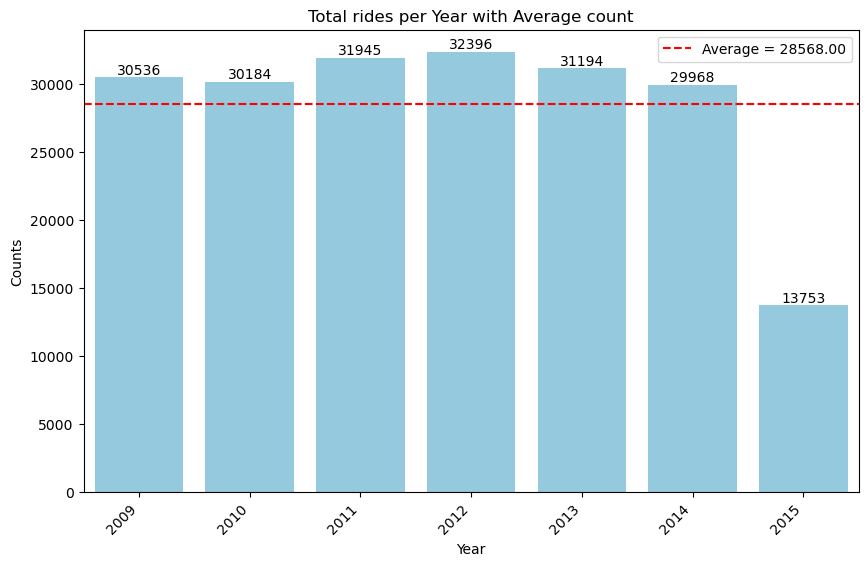

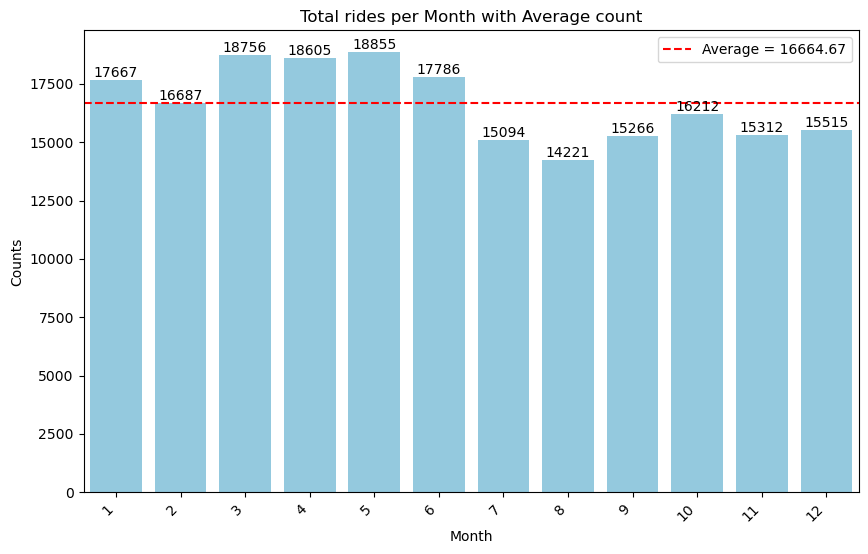

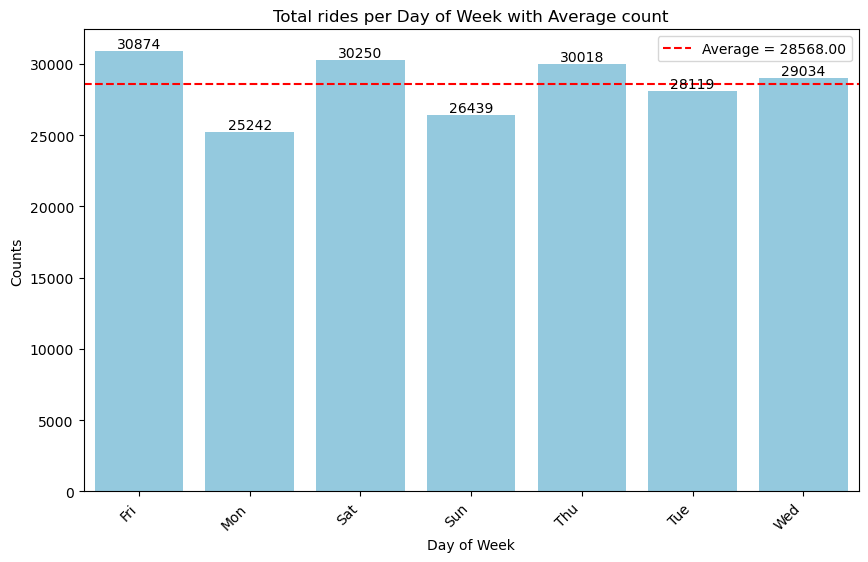

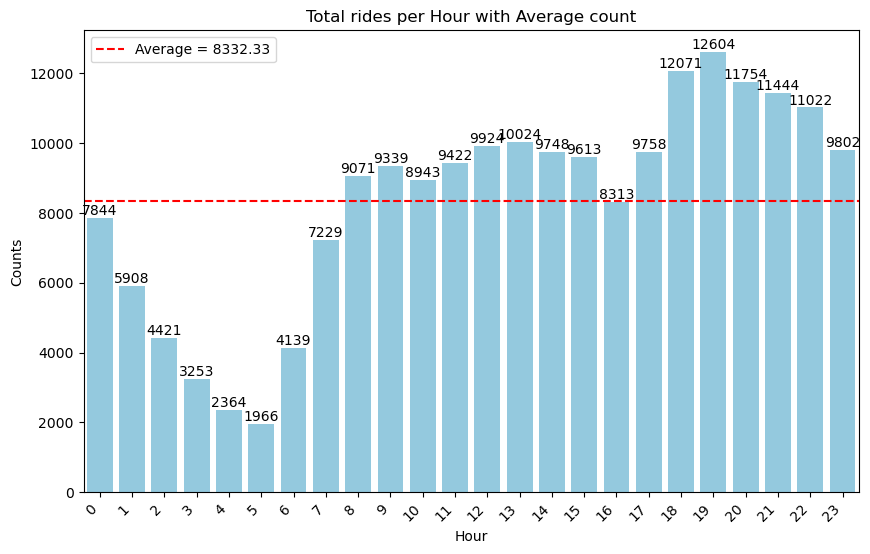

In [56]:
def plot_value_counts_with_avg(df, column_name):

    # Calculate value counts for the specified column
    value_counts = df[column_name].value_counts().sort_index()

    # Calculate the average count
    average_count = value_counts.mean()

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=value_counts.index, y=value_counts.values, color='skyblue')

    # Add a horizontal line for the average value count
    plt.axhline(average_count, color='red', linestyle='--', label=f'Average = {average_count:.2f}')

    for index, value in enumerate(value_counts.values):
        plt.text(index, value + 0.5, str(value), ha='center', va='bottom')


    # Add title and labels
    plt.title(f'Total rides per {column_name} with Average count')
    plt.ylabel('Counts')
    plt.xlabel(column_name)

    # Rotate x labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Add a legend
    plt.legend()

    # Display the plot
    plt.show()


# Plot value counts for 'Year'
plot_value_counts_with_avg(df, 'Year')

# Plot value counts for 'Month'
plot_value_counts_with_avg(df, 'Month')

# Plot value counts for 'Day'
plot_value_counts_with_avg(df, 'Day of Week')

# Plot value counts for 'Hour'
plot_value_counts_with_avg(df, 'Hour')

#### 2.2 Data overview of numerical variables.

<Figure size 1200x600 with 0 Axes>

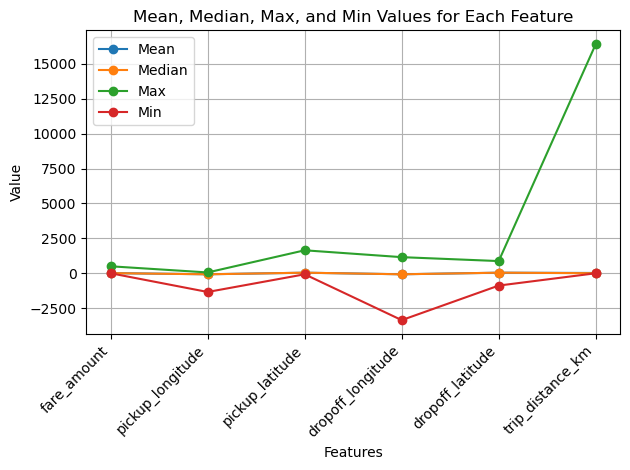

In [57]:
df_numerical = df.select_dtypes(include=['number'])

threshold = 25  # For unique values >24 what is considered "continuous"
continuous_columns = [col for col in df_numerical.columns if df_numerical[col].nunique() > threshold]

df_continuous = df_numerical[continuous_columns]

mean_values = df_continuous.mean()
median_values = df_continuous.median()
max_values = df_continuous.max()
min_values = df_continuous.min()

# Step 2: Combine these into a DataFrame for easier plotting
stats_df = pd.DataFrame({
    'Mean': mean_values,
    'Median': median_values,
    'Max': max_values,
    'Min': min_values
})

# Step 3: Create the line plot
plt.figure(figsize=(12, 6))
stats_df.plot(kind='line', marker='o')

# Add title and labels
plt.title('Mean, Median, Max, and Min Values for Each Feature')
plt.ylabel('Value')
plt.xlabel('Features')

# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

#### 2.3 Distribution of numerical variables.

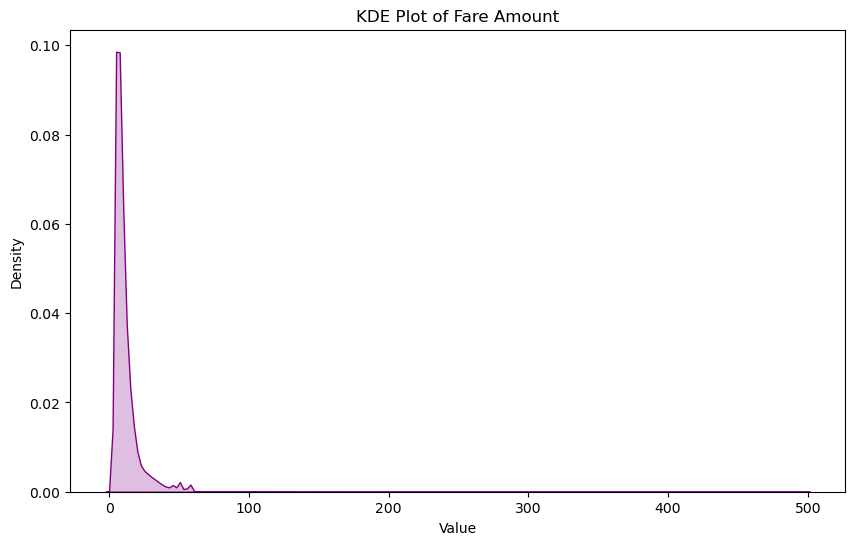

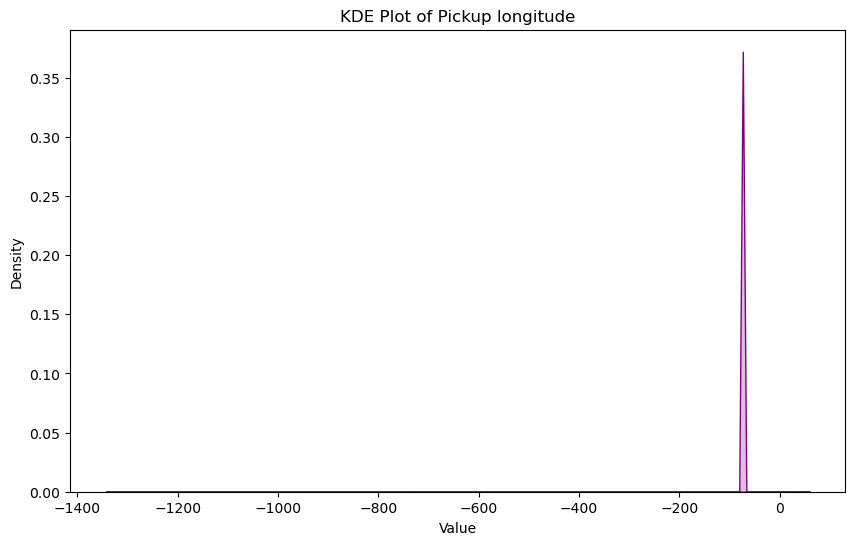

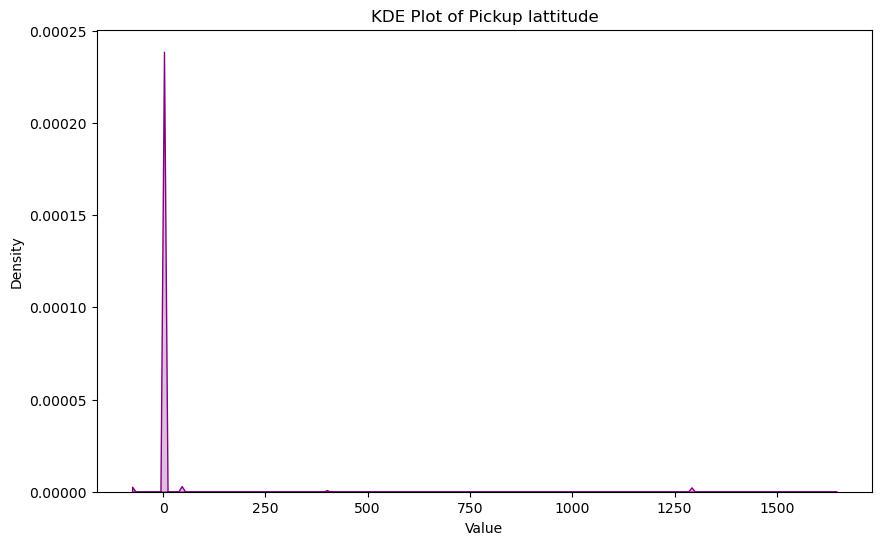

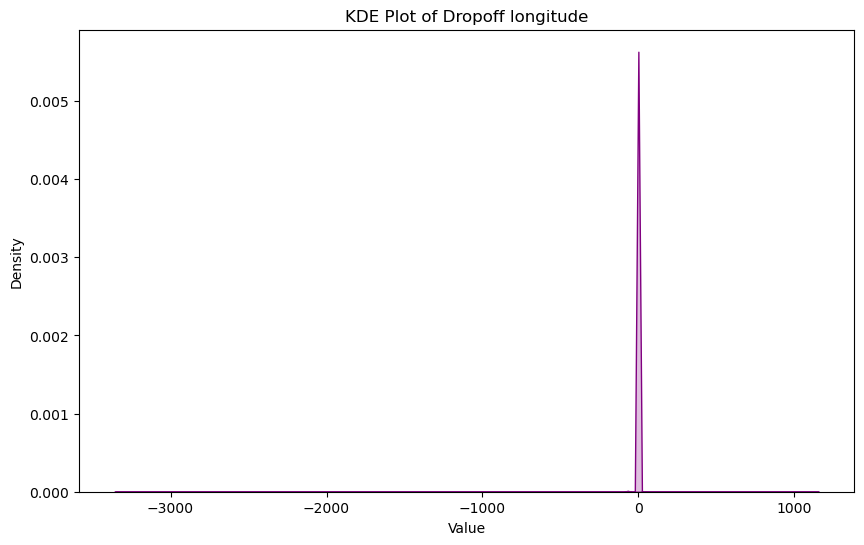

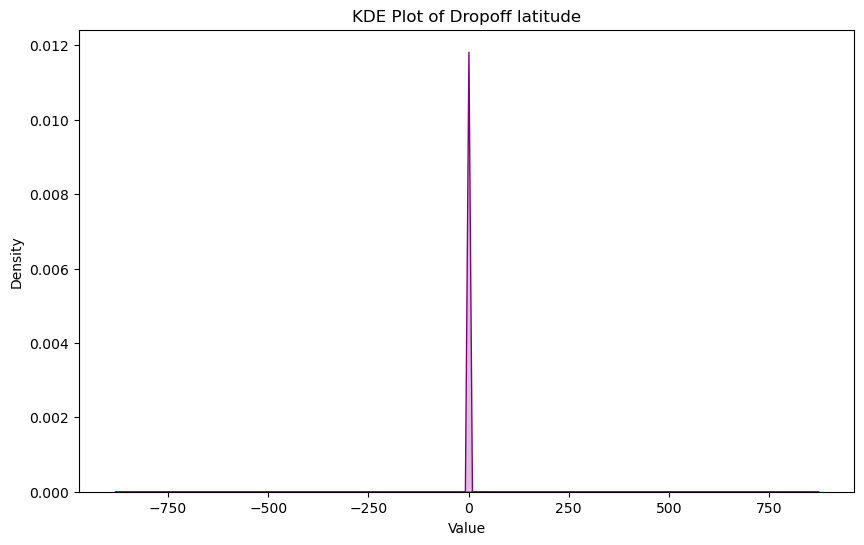

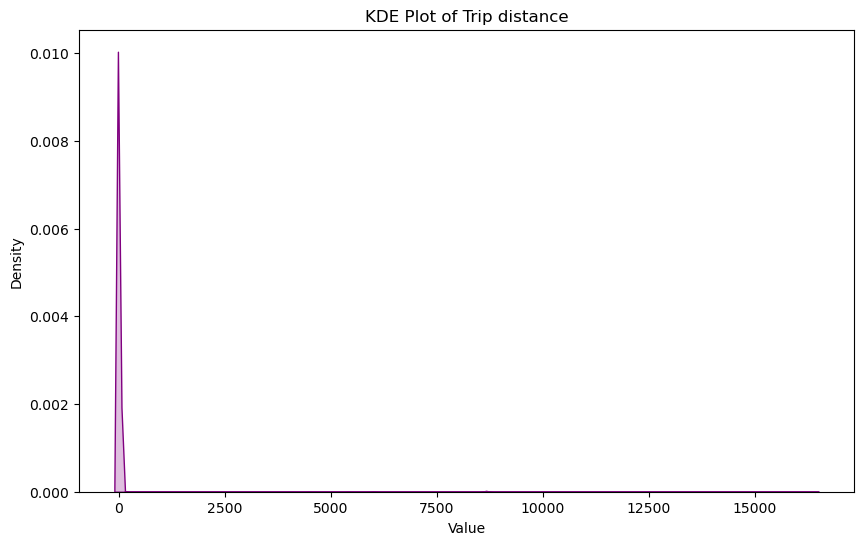

In [58]:
def plot_kde(df_continuous, column_name, plot_title='KDE Plot of Column'):
   
    # Check if the column exists in the DataFrame
    if column_name not in df_continuous.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    # Generate the KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df[column_name], fill=True, color='purple')

    # Add title and labels
    plt.title(plot_title)
    plt.xlabel('Value')
    plt.ylabel('Density')

    # Display the plot
    plt.show()

# Example usage:
# Assuming df_numeric is your DataFrame with numeric variables
# and you want to plot the KDE plot for a specific column
plot_kde(df_continuous, 'fare_amount', plot_title='KDE Plot of Fare Amount')
plot_kde(df_continuous, 'pickup_longitude', plot_title='KDE Plot of Pickup longitude')
plot_kde(df_continuous, 'pickup_latitude', plot_title='KDE Plot of Pickup lattitude')
plot_kde(df_continuous, 'dropoff_longitude', plot_title='KDE Plot of Dropoff longitude')
plot_kde(df_continuous, 'dropoff_latitude', plot_title='KDE Plot of Dropoff latitude')
plot_kde(df_continuous, 'trip_distance_km', plot_title='KDE Plot of Trip distance')

#### 2.4 Temporal analysis

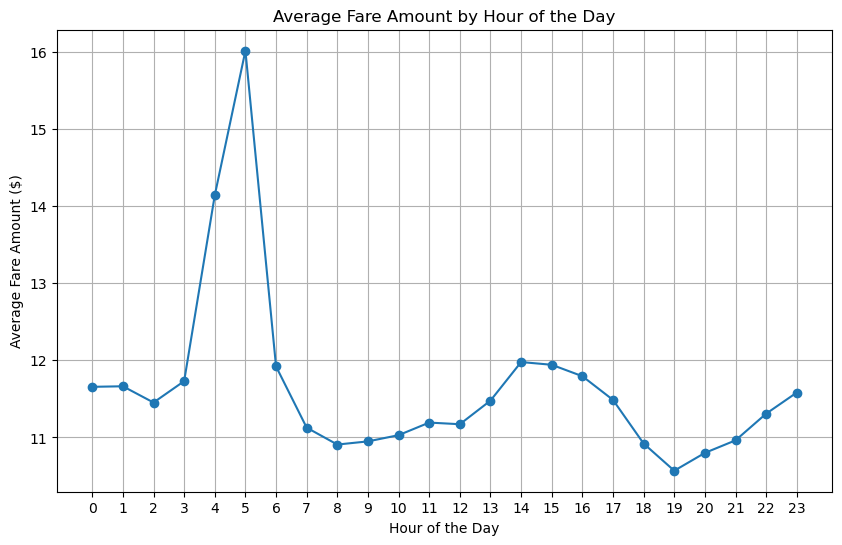

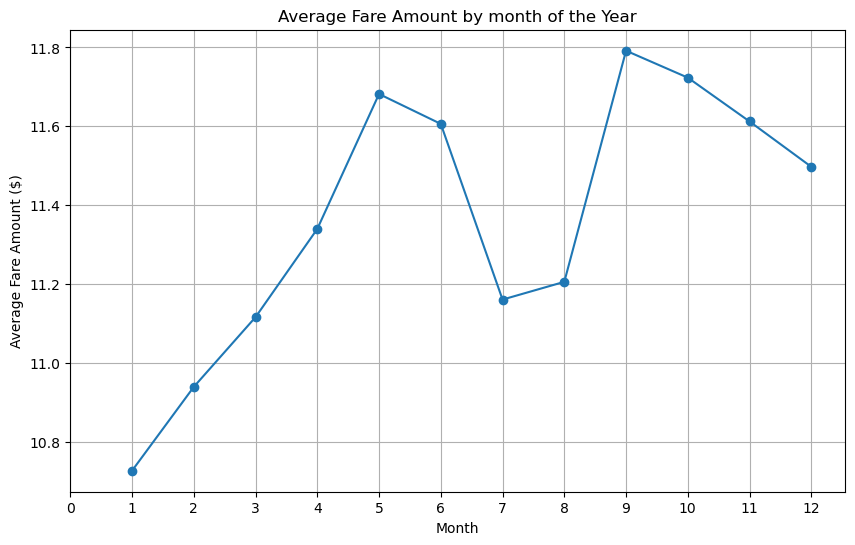

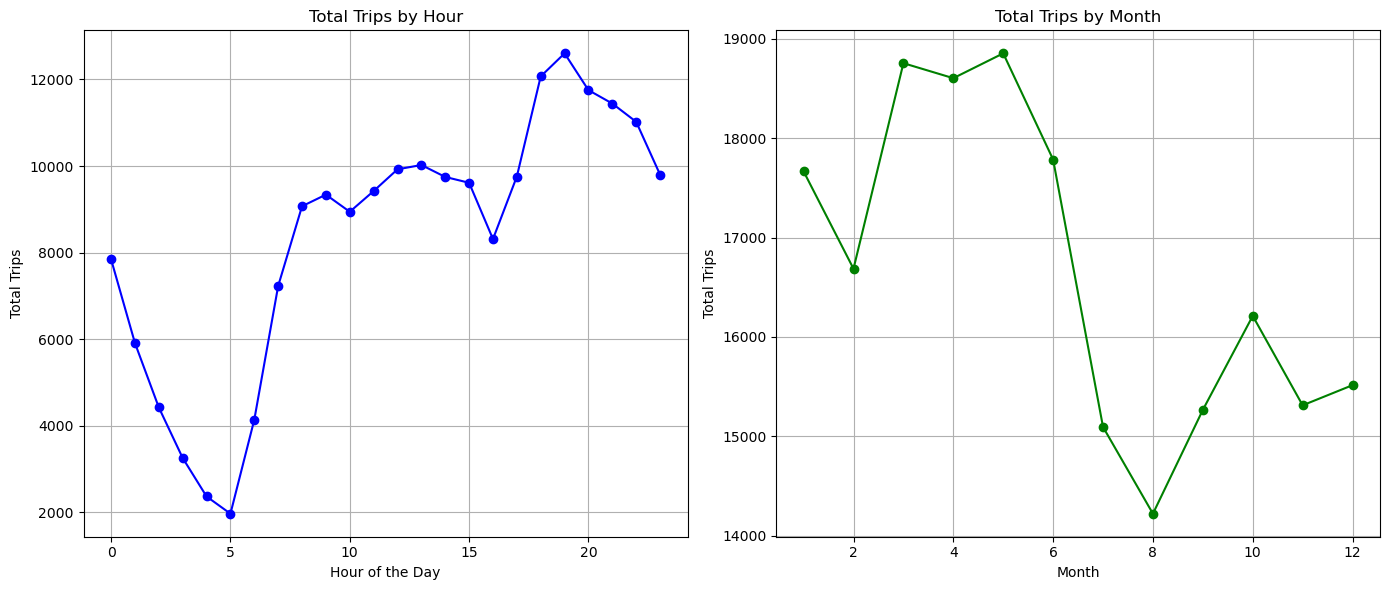

In [59]:
average_fare_by_hour = df.groupby('Hour')['fare_amount'].mean()
average_fare_by_month = df.groupby('Month')['fare_amount'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_fare_by_hour.index, average_fare_by_hour.values, marker='o')
plt.title('Average Fare Amount by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Fare Amount ($)')
plt.xticks(range(0, 24))  # Ensure all hours are labeled
plt.grid(True)
plt.figure(figsize=(10, 6))
plt.plot(average_fare_by_month.index, average_fare_by_month.values, marker='o')
plt.title('Average Fare Amount by month of the Year')
plt.xlabel('Month')
plt.ylabel('Average Fare Amount ($)')
plt.xticks(range(0, 13))  # Ensure all hours are labeled
plt.grid(True)
plt.show()

rush_hour = df.groupby('Hour')['counter'].sum()
rush_month = df.groupby('Month')['counter'].sum()

plt.figure(figsize=(14, 6))

# Line plot for rush_hour
plt.subplot(1, 2, 1)
plt.plot(rush_hour.index, rush_hour.values, marker='o', color='blue')
plt.title('Total Trips by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Trips')
plt.grid(True)

# Line plot for rush_month
plt.subplot(1, 2, 2)
plt.plot(rush_month.index, rush_month.values, marker='o', color='green')
plt.title('Total Trips by Month')
plt.xlabel('Month')
plt.ylabel('Total Trips')
plt.grid(True)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### 2.5 descriptive statistics of Price and Distance before data cleaning.

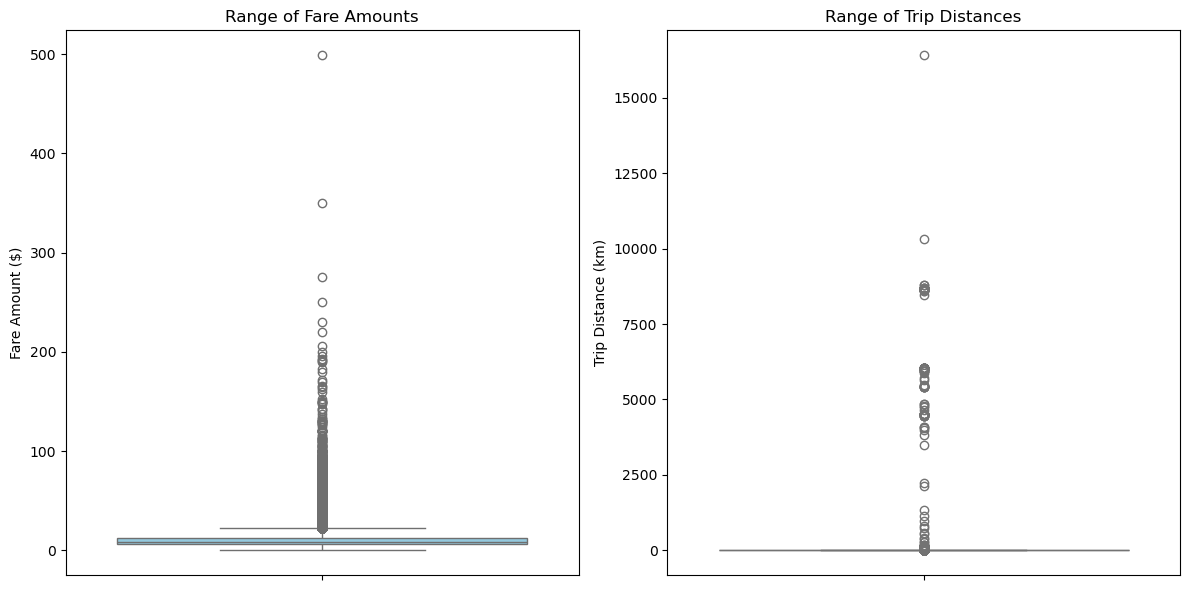

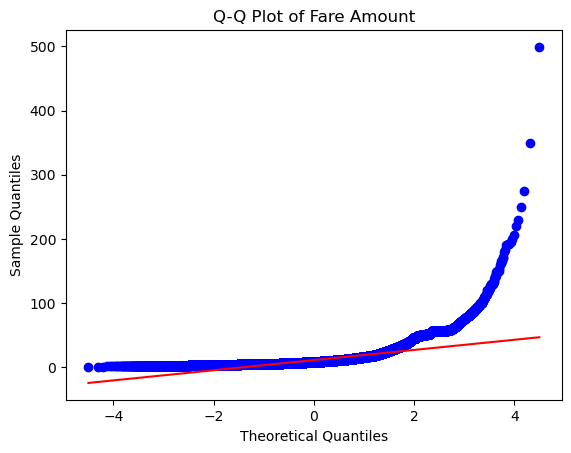

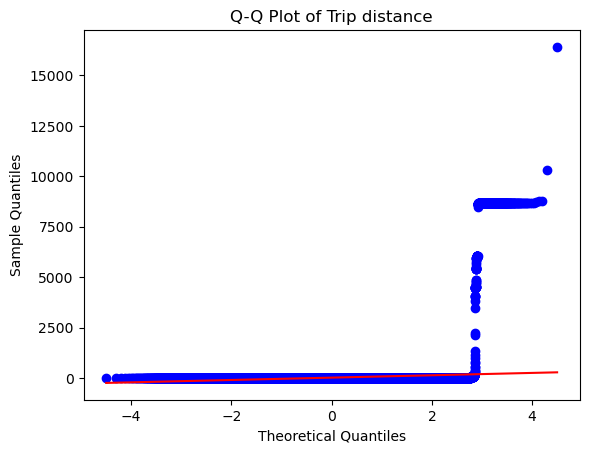

In [60]:
plt.figure(figsize=(12, 6))

# Create a subplot for fare amount
plt.subplot(1, 2, 1)
sns.boxplot(y=df['fare_amount'], color='skyblue')
plt.title('Range of Fare Amounts')
plt.ylabel('Fare Amount ($)')
plt.xlabel('')

# Create a subplot for trip distance
plt.subplot(1, 2, 2)
sns.boxplot(y=df['trip_distance_km'], color='lightgreen')
plt.title('Range of Trip Distances')
plt.ylabel('Trip Distance (km)')
plt.xlabel('')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

stats.probplot(df['fare_amount'], dist="norm", plot=plt)

# Add title and labels
plt.title('Q-Q Plot of Fare Amount')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Show plot
plt.show()

stats.probplot(df['trip_distance_km'], dist="norm", plot=plt)

# Add title and labels
plt.title('Q-Q Plot of Trip distance')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Show plot
plt.show()

### 2.6 Descriptive statistics of Price and Distance before data cleaning.

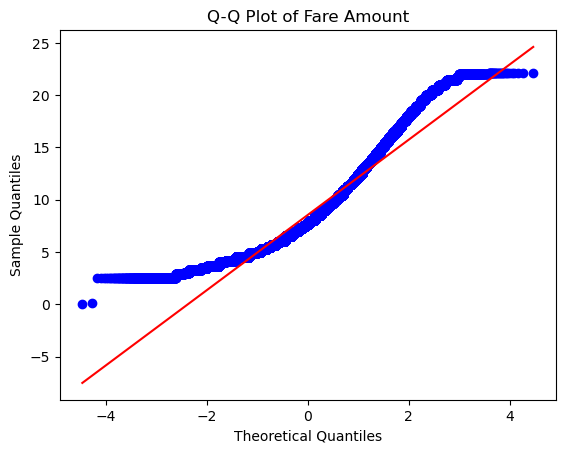

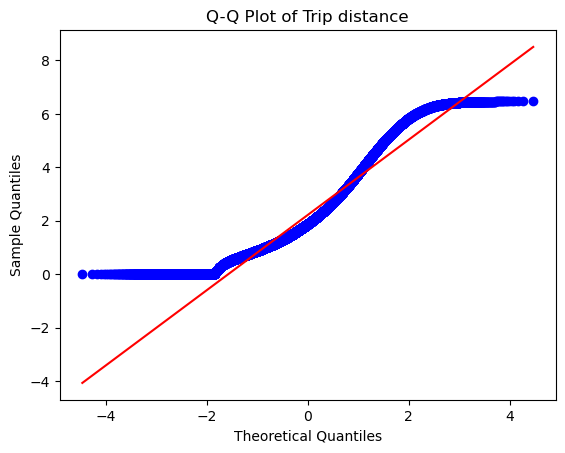

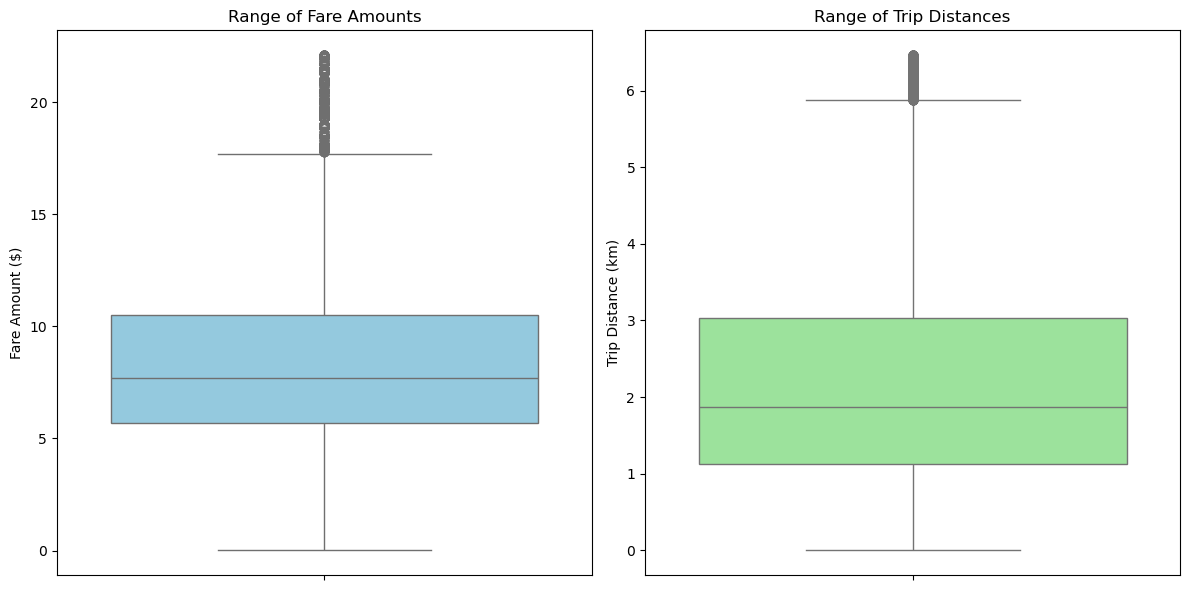

In [61]:
stats.probplot(df_clean['fare_amount'], dist="norm", plot=plt)

# Add title and labels
plt.title('Q-Q Plot of Fare Amount')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Show plot
plt.show()

stats.probplot(df_clean['trip_distance_km'], dist="norm", plot=plt)

# Add title and labels
plt.title('Q-Q Plot of Trip distance')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

# Show plot
plt.show()

plt.figure(figsize=(12, 6))

# Create a subplot for fare amount
plt.subplot(1, 2, 1)
sns.boxplot(y=df_clean['fare_amount'], color='skyblue')
plt.title('Range of Fare Amounts')
plt.ylabel('Fare Amount ($)')
plt.xlabel('')

# Create a subplot for trip distance
plt.subplot(1, 2, 2)
sns.boxplot(y=df_clean['trip_distance_km'], color='lightgreen')
plt.title('Range of Trip Distances')
plt.ylabel('Trip Distance (km)')
plt.xlabel('')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

#### 2.7 Correlation check before data cleaning

<Figure size 1200x800 with 0 Axes>

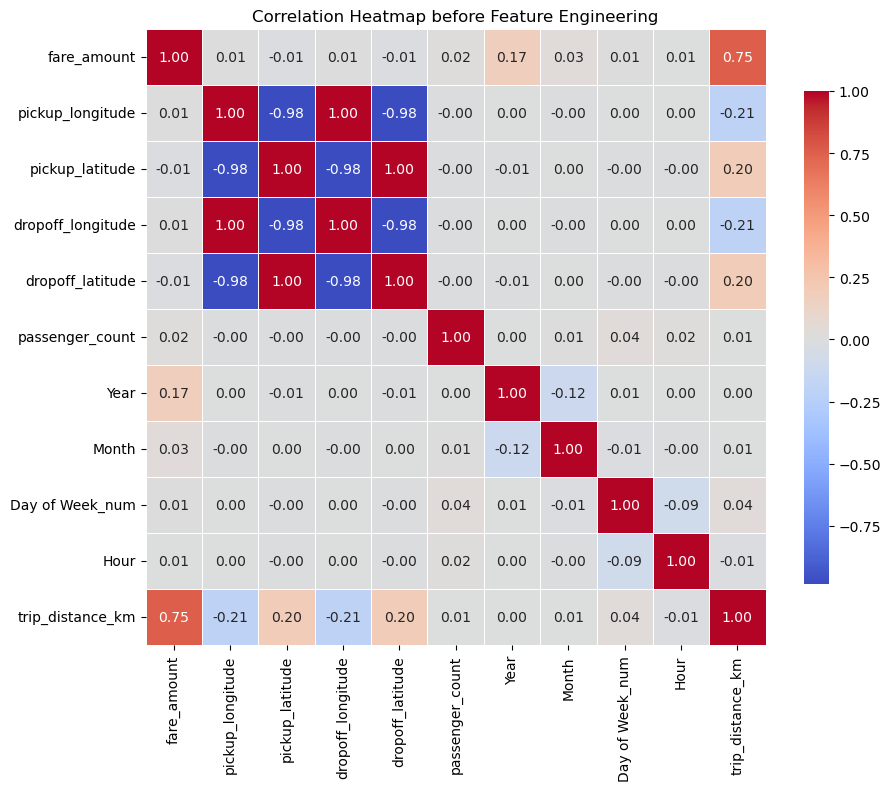

In [62]:
df_numerical = df_clean.select_dtypes(include=['number'])
df_numerical = df_numerical.drop(columns=['counter'])
correlation_matrix = df_numerical.corr()

plt.figure(figsize=(12, 8))

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(10, 8))  # Optional: Adjust the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap before Feature Engineering")  # Set the title
plt.show() 

#### 2.8 Data vizualition on pick up locations

In [ ]:
import plotly.express as px

# Create the scatter mapbox plot
fig = px.scatter_mapbox(
    df_clean,
    lat="pickup_latitude",
    lon="pickup_longitude",
    zoom=3,
    height=400
)

# Set the mapbox style (you can choose from various map styles)
fig.update_layout(mapbox_style="open-street-map")

# Show the plot
fig.show()

#### 2.9 Passenger behaviour analysis

/var/folders/f6/3j2ss2s17kng3g2xrm_hz4sm0000gn/T/ipykernel_46350/3621904193.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='passenger_count', data=df_clean, palette=custom_palette)
/var/folders/f6/3j2ss2s17kng3g2xrm_hz4sm0000gn/T/ipykernel_46350/3621904193.py:4: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(x='passenger_count', data=df_clean, palette=custom_palette)


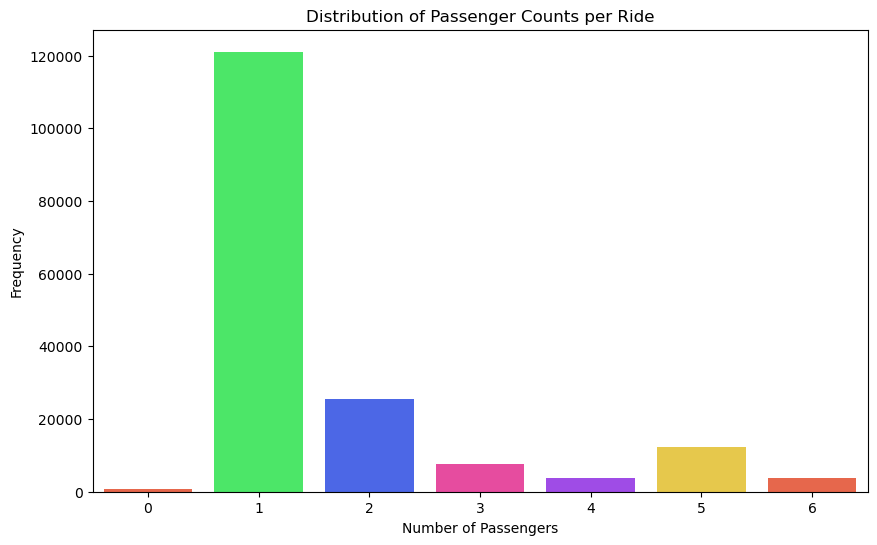

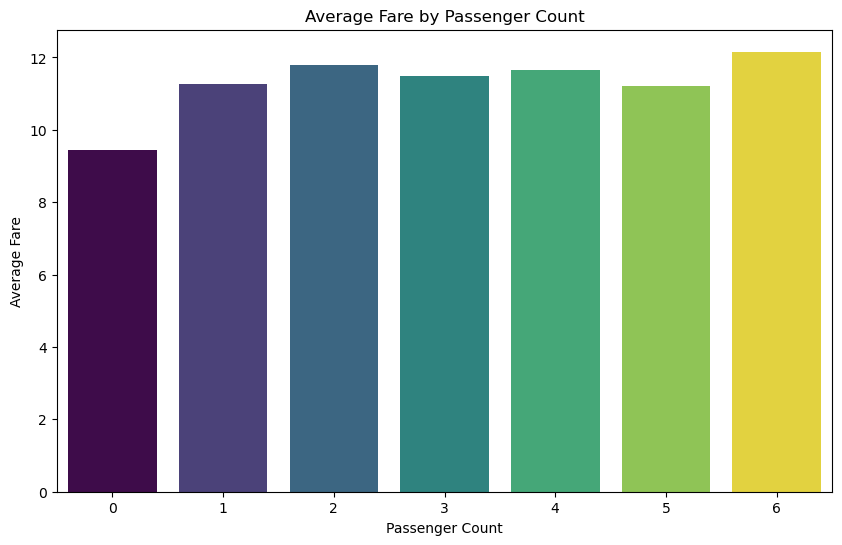

In [63]:
custom_palette = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#A133FF', '#FFD733']  # Example hex color codes

plt.figure(figsize=(10, 6))
sns.countplot(x='passenger_count', data=df_clean, palette=custom_palette)
plt.title('Distribution of Passenger Counts per Ride')
plt.xlabel('Number of Passengers')
plt.ylabel('Frequency')
plt.show()

def plot_avg_fare_by_passenger_count(df, fare_amount, passenger_count):

    avg_fare_by_passenger = df.groupby(passenger_count)[fare_amount].mean().reset_index()

    # Step 2: Create the bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=passenger_count, y=fare_amount,hue=passenger_count,  data=avg_fare_by_passenger, palette='viridis',legend=False)

    # Step 3: Add title and labels
    plt.title('Average Fare by Passenger Count')
    plt.xlabel('Passenger Count')
    plt.ylabel('Average Fare')

    # Display the plot
    plt.show()

# Example usage:
# Assuming df is your DataFrame containing 'fare_amount' and 'passenger_count'
plot_avg_fare_by_passenger_count(df, 'fare_amount', 'passenger_count')

#### 2.10 Bivariate analysis

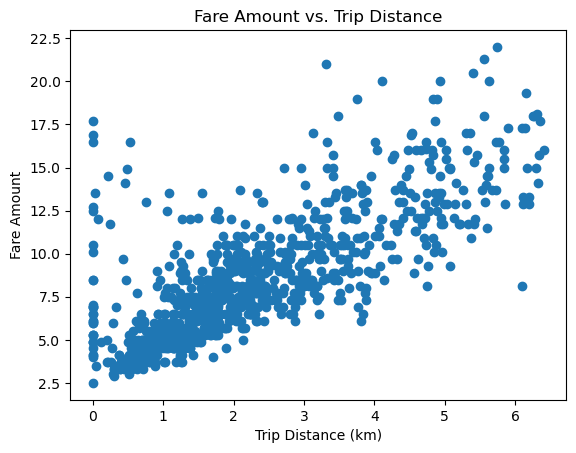

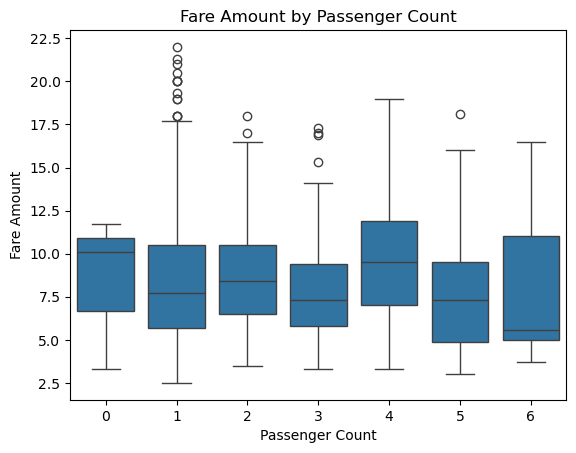

In [65]:
df1 = df_clean.head(1000)
plt.scatter(df1['trip_distance_km'], df1['fare_amount'])
plt.title('Fare Amount vs. Trip Distance')
plt.xlabel('Trip Distance (km)')
plt.ylabel('Fare Amount')
plt.show()

sns.boxplot(x='passenger_count', y='fare_amount', data=df1)
plt.title('Fare Amount by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount')
plt.show()

### 3. Feature engineering

In [43]:
# Converting categorical variables like day, month, hour using onsine-cosine one hot coding.
df_clean['Month_sin'] = np.sin(2 * np.pi * df_clean['Month'] / 12)
df_clean['Month_cos'] = np.cos(2 * np.pi * df_clean['Month'] / 12)

df_clean['Hour_sin'] = np.sin(2 * np.pi * df_clean['Hour'] / 24)
df_clean['Hour_cos'] = np.cos(2 * np.pi * df_clean['Hour'] / 24)

df_clean['day_sin'] = np.sin(2 * np.pi * df_clean['Day of Week_num'] / 24)
df_clean['day_cos'] = np.cos(2 * np.pi * df_clean['Day of Week_num'] / 24)

In [45]:
# Categorizing variables into target and features.
target = df_clean['fare_amount']
features = df_clean.drop(columns=['fare_amount','pickup_datetime','counter','Month','Day of Week_num','Day of Week','Hour'])
features.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'Year', 'trip_distance_km',
       'Month_sin', 'Month_cos', 'Hour_sin', 'Hour_cos', 'day_sin', 'day_cos'],
      dtype='object')

In [12]:
# split data into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state=0)

### 4. Modeling

#### 4.1 GradientBoostingRegressor

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Assuming features and target are your features and target
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# # Step 4: Feature Scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Initialize and train the Gradient Boosting Regressor
model = GradientBoostingRegressor(max_depth=10, n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predict the target for the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model using Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Step 7: Making Predictions
# Example: Predict the fare amount for the first few rows of the test set
predicted_fares = model.predict(X_test_scaled[:5])
print(f'Predicted Fares: {predicted_fares}')
print(f'Actual Fares: {y_test[:5].values}')

Mean Squared Error: 3.5203388851588464
R-squared: 0.7468280105404896
Predicted Fares: [ 7.91341369  8.7293212  10.73610855  8.75029793  6.41798623]
Actual Fares: [ 7.7  8.5 11.3  8.5  5.7]


#### 4.2 RandomForestRegressor

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 4: Feature Scaling
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# If you want to scale y_train and y_test (which is common in regression tasks)
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Step 5: Model Selection and Training
# Using RandomForestRegressor as an example
model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 6: Model Evaluation
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Step 7: Making Predictions
# Example: Predict the fare amount for the first few rows of the test set
predicted_fares = model.predict(X_test_scaled[:5])
print(f'Predicted Fares: {predicted_fares}')
print(f'Actual Fares: {y_test[:5].values}')

Mean Squared Error: 3.8548095795009907
R-squared: 0.7227739027216387
Predicted Fares: [ 7.9052   9.4906  10.3386   8.63766  6.333  ]
Actual Fares: [ 7.7  8.5 11.3  8.5  5.7]


#### 4.3 DecisionTreeRegressor

In [19]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming features and target are your features and target
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 4: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Decision Tree Regressor
dt = DecisionTreeRegressor(max_depth=10)
dt.fit(X_train, y_train)

# Predict the target for the test set
y_pred = dt.predict(X_test)

# Evaluate the model using Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Step 7: Making Predictions
# Example: Predict the fare amount for the first few rows of the test set
predicted_fares = model.predict(X_test_scaled[:5])
print(f'Predicted Fares: {predicted_fares}')
print(f'Actual Fares: {y_test[:5].values}')

Mean Squared Error: 4.498888193719532
R-squared: 0.6764537416662706
Predicted Fares: [12.6194     13.9195     14.75094    10.57006667 11.24990667]
Actual Fares: [ 7.7  8.5 11.3  8.5  5.7]


#### 4.4 LinearRegression

Mean Squared Error: 4.8307334355128475
R-squared: 0.6525884483526996
Predicted Fares: [ 6.37689311 11.04575934 10.12074523  8.94930795  6.30371844]
Actual Fares: [ 7.7  8.5 11.3  8.5  5.7]


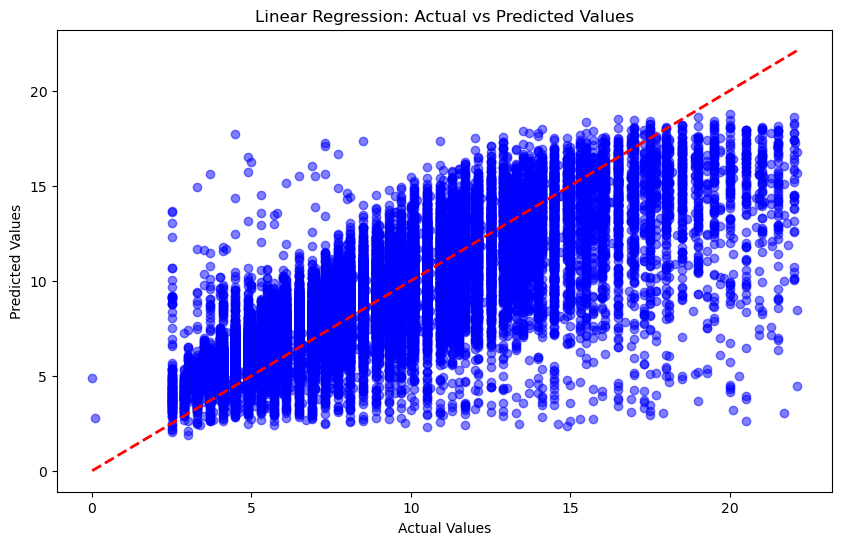

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming features and target are your features and target
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict the target for the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model using Mean Squared Error and R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Step 7: Making Predictions
# Example: Predict the fare amount for the first few rows of the test set
predicted_fares = model.predict(X_test_scaled[:5])
print(f'Predicted Fares: {predicted_fares}')
print(f'Actual Fares: {y_test[:5].values}')

# Step 8: Plotting Actual vs Predicted values
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs predicted values
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)

# Plot a diagonal line for perfect predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)

# Add labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression: Actual vs Predicted Values')

# Show the plot
plt.show()


#### 4.5 KNeighborsRegressor

In [21]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming features and target are your features and target
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize KNN Regressor
knn_model = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors

# Train the KNN model on the training data
knn_model.fit(X_train_scaled, y_train)

# Predict the target for the test set using KNN
knn_pred = knn_model.predict(X_test_scaled)

# Evaluate the KNN model using Mean Squared Error and R-squared
knn_mse = mean_squared_error(y_test, knn_pred)
knn_r2 = r2_score(y_test, knn_pred)

print(f'KNN Regression - Mean Squared Error: {knn_mse}')
print(f'KNN Regression - R-squared: {knn_r2}')

# Step 7: Making Predictions
# Example: Predict the fare amount for the first few rows of the test set
predicted_fares = model.predict(X_test_scaled[:5])
print(f'Predicted Fares: {predicted_fares}')
print(f'Actual Fares: {y_test[:5].values}')



KNN Regression - Mean Squared Error: 5.350677350713345
KNN Regression - R-squared: 0.6151956746133221
Predicted Fares: [ 6.37689311 11.04575934 10.12074523  8.94930795  6.30371844]
Actual Fares: [ 7.7  8.5 11.3  8.5  5.7]


#### 4.6 Ridge and Lasso

In [22]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming features and target are your features and target
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Ridge and Lasso Regressors
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.1)

# Train the Ridge model on the training data
ridge_model.fit(X_train_scaled, y_train)

# Train the Lasso model on the training data
lasso_model.fit(X_train_scaled, y_train)

# Predict the target for the test set using Ridge
ridge_pred = ridge_model.predict(X_test_scaled)

# Predict the target for the test set using Lasso
lasso_pred = lasso_model.predict(X_test_scaled)

# Evaluate the Ridge model using Mean Squared Error and R-squared
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

# Evaluate the Lasso model using Mean Squared Error and R-squared
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

print(f'Ridge Regression - Mean Squared Error: {ridge_mse}')
print(f'Ridge Regression - R-squared: {ridge_r2}')
print(f'Lasso Regression - Mean Squared Error: {lasso_mse}')
print(f'Lasso Regression - R-squared: {lasso_r2}')

# Step 7: Making Predictions
# Example: Predict the fare amount for the first few rows of the test set
predicted_fares = model.predict(X_test_scaled[:5])
print(f'Predicted Fares: {predicted_fares}')
print(f'Actual Fares: {y_test[:5].values}')

Ridge Regression - Mean Squared Error: 4.841997738403281
Ridge Regression - R-squared: 0.6517783541925412
Lasso Regression - Mean Squared Error: 4.998732060476569
Lasso Regression - R-squared: 0.6405065018424253
Predicted Fares: [ 6.37689311 11.04575934 10.12074523  8.94930795  6.30371844]
Actual Fares: [ 7.7  8.5 11.3  8.5  5.7]


### 5. Cross validation

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize models
model_gb = GradientBoostingRegressor(max_depth=10, n_estimators=100, random_state=42)
model_rf = RandomForestRegressor(n_estimators=500, random_state=42)

# Define the k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Cross-validation with Gradient Boosting
cv_results_gb = cross_val_score(model_gb, features, target, cv=kf, scoring='neg_mean_squared_error')

# Cross-validation with Random Forest
cv_results_rf = cross_val_score(model_rf, features, target, cv=kf, scoring='neg_mean_squared_error')

# Convert the negative MSE to positive
mse_gb = -cv_results_gb
mse_rf = -cv_results_rf

# Calculate the average and standard deviation of the MSE for each model
print(f"Gradient Boosting - Mean MSE: {mse_gb.mean()}, Std MSE: {mse_gb.std()}")
print(f"Random Forest - Mean MSE: {mse_rf.mean()}, Std MSE: {mse_rf.std()}")


Gradient Boosting - Mean MSE: 3.606071816414448, Std MSE: 0.08871563634304289
Random Forest - Mean MSE: 3.9411217994290366, Std MSE: 0.09597131272465449


### 6. Hyperparameter tuning with Grid search on Gradient boosting model and DecisionTreeRegressor

In [24]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'features' and 'target' are already defined
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)

# Define the parameter grid for DecisionTreeRegressor
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit the GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.3s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.3s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_split=5; total time=   0.3s
[CV] END criterion=squared_error, max_depth=3, min_samples_leaf=1, min_samples_sp

KeyboardInterrupt: 